# Bike Sharing Demand

kaggle에서 다운받아서 불러오기

In [6]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/   # kaggl.json위치 지정
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c bike-sharing-demand

100% 189k/189k [00:00<00:00, 1.71MB/s]
100% 189k/189k [00:00<00:00, 1.69MB/s]


In [8]:
!unzip /content/bike-sharing-demand.zip -d  /content/bike-sharing-demand/

Archive:  /content/bike-sharing-demand.zip
  inflating: /content/bike-sharing-demand/sampleSubmission.csv  
  inflating: /content/bike-sharing-demand/test.csv  
  inflating: /content/bike-sharing-demand/train.csv  


In [83]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns #시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import calendar 
from datetime import datetime


train = pd.read_csv('/content/bike-sharing-demand/train.csv')
test = pd.read_csv('/content/bike-sharing-demand/test.csv')

In [58]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [59]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [60]:
"""
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
"""
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [61]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### datetime 컬럼을 세부사항으로 나누기


분리한 tempDate를 가지고 년-월-일을 이용하여 year,month,day 그리고 weekday column을 추출한다.\
weekday는 calendar패키지와 datetime패키지를 활용한다.

In [84]:
train['tempDate'] = train.datetime.apply(lambda x:x.split())


train['year'] = train.tempDate.apply(lambda x:x[0].split('-')[0])
train['month'] = train.tempDate.apply(lambda x:x[0].split('-')[1])
train['day'] = train.tempDate.apply(lambda x:x[0].split('-')[2])

train['weekday'] = train.tempDate.apply(lambda x:calendar.day_name[datetime.strptime(x[0],"%Y-%m-%d").weekday()])

train['hour'] = train.tempDate.apply(lambda x:x[1].split(':')[0])

#필요를 다한 tempDate column을 drop함
train = train.drop('tempDate',axis=1)

In [63]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,Saturday,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,01,01,Saturday,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,01,01,Saturday,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,01,01,Saturday,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,01,01,Saturday,04


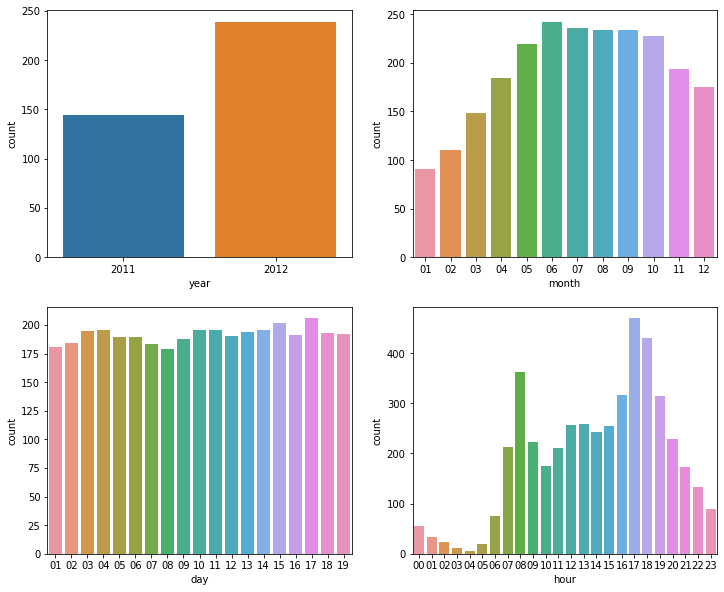

In [79]:
#각각의 속성과 예측의 결과값으로 쓰이는 count값과의 관계 파악

#년도와 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year',y='count',data=train.groupby('year')['count'].mean().reset_index())

#month와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())

#day와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='day',y='count',data=train.groupby('day')['count'].mean().reset_index())

#hour와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index())

2011년 데이터가 우선 많고 여름철에 많이 몰려있으며 날짜에서 의미는 찾기 힘들다.\
또한 시간은 7-9시, 16-19시에 몰려있는 것으로 봐서 출근 시간대에 몰려있는 것을 알 수 있다.

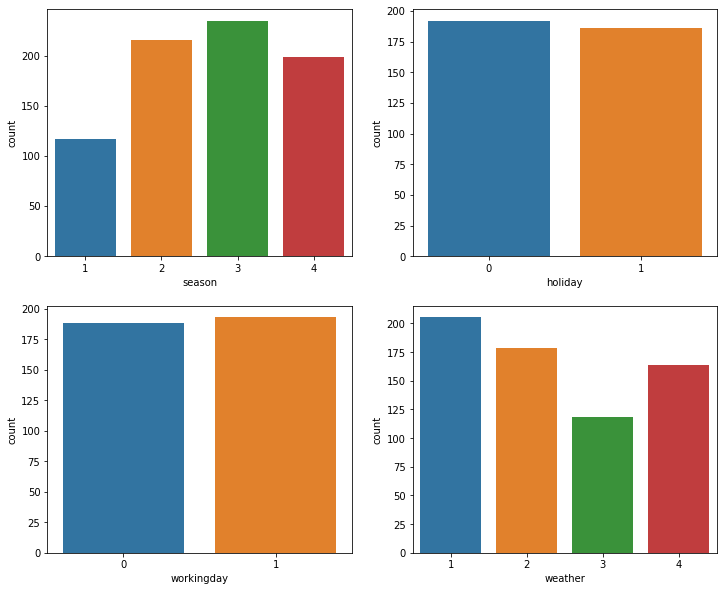

In [82]:
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index())

#휴일 여부와 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index())

#작업일 여부와 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index())

#날씨와 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index())

계절은 여름, 가을. 날씨는 좋을 때 많이 사용한다. -> 당연한 얘기일수도


계절을 체크하는데에 있어 데이터 상 오류가 있어 해당 Column을 수정하는 과정이 필요해보인다.

In [66]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

#apply() 내장함수는 split(),map(),join(),filter()등 과 함꼐 필수적으로 숙지해야 할 함수이다.
train['season'] = train.month.apply(badToRight)

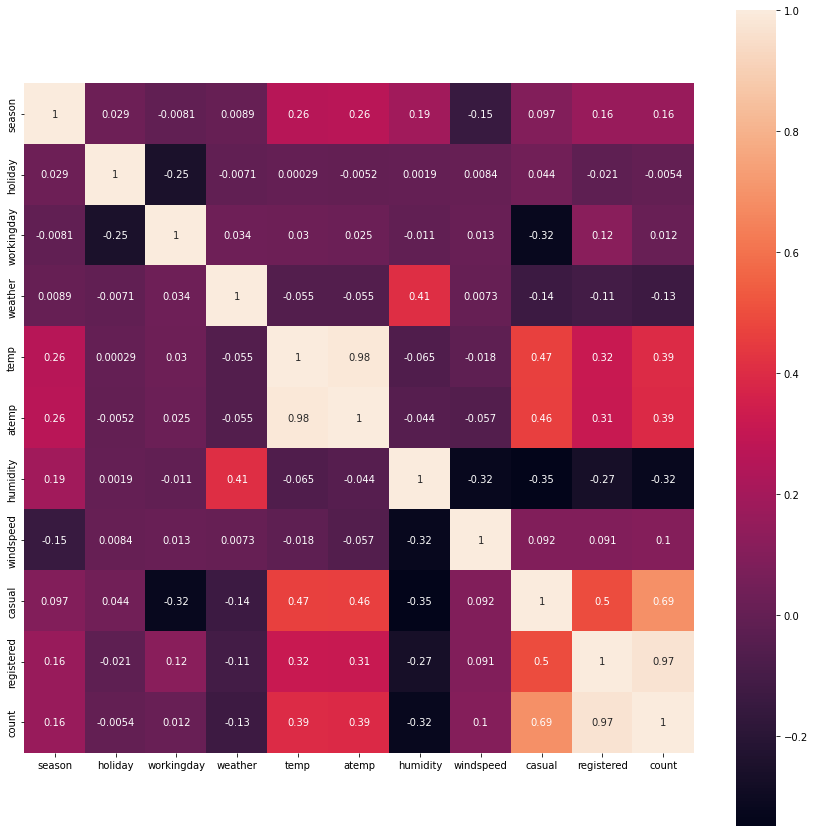

In [75]:
#각각의 컬럼들 간의 상관계수를 heatmap을 통해 시각화

fig = plt.figure(figsize=[15,15])
ax = sns.heatmap(train.corr(),annot=True,square=True)

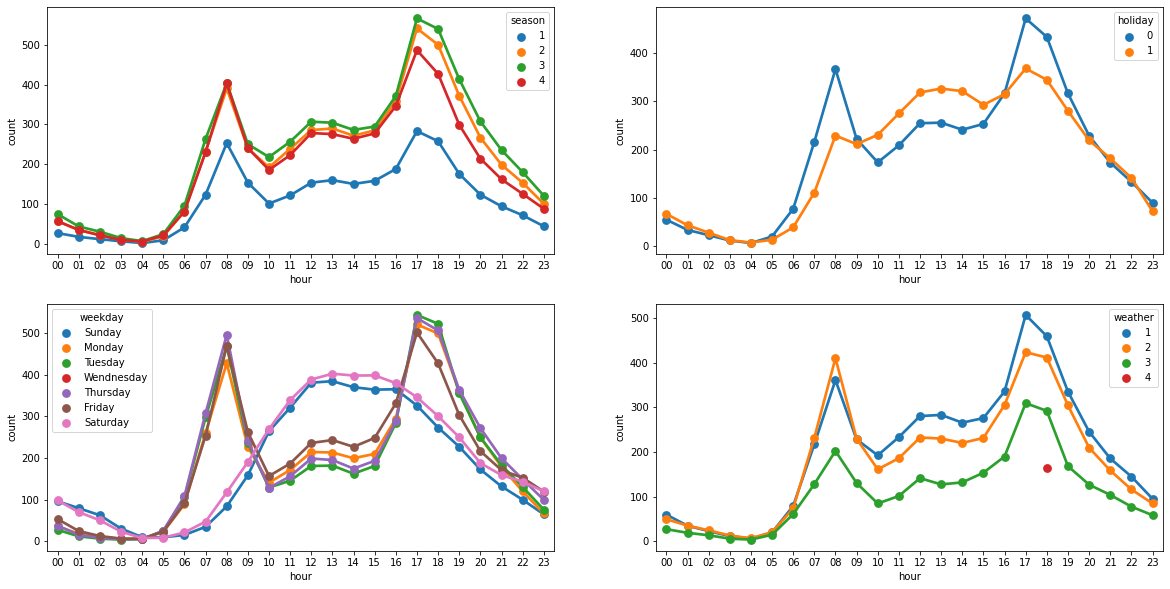

In [90]:
#heatmap 상관관계를 참조하여 이전의 시각화와는 달리 두 개의 서로다른 컬럼이 적용된 count를 시각화해보자

#시간과 계절에 따른 count
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.pointplot(x='hour',y='count',hue='season',data=train.groupby(['season','hour'])['count'].mean().reset_index())

#시간과 휴일 여부에 따른 count
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.pointplot(x='hour',y='count',hue='holiday',data=train.groupby(['holiday','hour'])['count'].mean().reset_index())

#시간과 휴일 여부에 따른 count
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.pointplot(x='hour',y='count',hue='weekday',hue_order=['Sunday','Monday','Tuesday','Wendnesday','Thursday','Friday','Saturday'],data=train.groupby(['weekday','hour'])['count'].mean().reset_index())

#시간과 날씨에 따른 count
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.pointplot(x='hour',y='count',hue='weather',data=train.groupby(['weather','hour'])['count'].mean().reset_index())

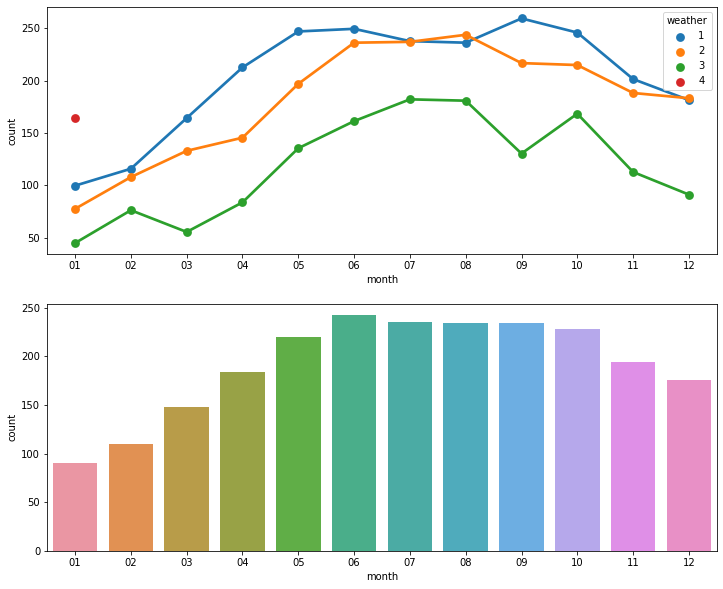

In [91]:
#달과 날씨에 따른 count 
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(2,1,1)
ax1 = sns.pointplot(x='month',y='count',hue='weather',data=train.groupby(['weather','month'])['count'].mean().reset_index())

#달별 count
ax2 = fig.add_subplot(2,1,2)
ax2 = sns.barplot(x='month',y='count',data=train.groupby('month')['count'].mean().reset_index())

In [92]:
"""
Windspeed 분포를 표현한 그래프에서 Windspeed가 0인 값들이 많았는데,
이는 실제로 0이었던지 or 값을 제대로 측정하지 못해서 0인지 두 개의 경우가 있다.
하지만 후자의 생각을 가지고 우리의 데이터를 활용하여 windspeed값을 부여해보자
"""

#머신러닝 모델에 훈련시킬 때는 문자열 값은 불가능하기 때문에 문자열을 카테고리화 하고 각각에 해당하는 값을 숫자로 변환해준다
train['weekday']= train.weekday.astype('category')

print(train['weekday'].cat.categories)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')


In [93]:
#0:Sunday --> 6:Saturday
train.weekday.cat.categories = ['5','1','6','0','4','2','3']

In [94]:
"""
RandomForest를 활용하여 Windspeed값을 부여해보자
하나의 데이터를 Windspeed가 0인 그리고 0이 아닌 데이터프레임으로 분리하고
학습시킬 0이 아닌 데이터 프레임에서는 Windspeed만 담긴 Series와 이외의 학습시킬 column들의 데이터프레임으로 분리한다
학습 시킨 후에 Windspeed가 0인 데이터 프레임에서 학습시킨 컬럼과 같게 추출하여 결과 값을 부여받은 후,
Windspeed가 0인 데이터프레임에 Windspeed값을 부여한다.
"""
from sklearn.ensemble import RandomForestRegressor

#Windspeed가 0인 데이터프레임
windspeed_0 = train[train.windspeed == 0]
#Windspeed가 0이 아닌 데이터프레임
windspeed_Not0 = train[train.windspeed != 0]

#Windspeed가 0인 데이터 프레임에 투입을 원치 않는 컬럼을 배제
windspeed_0_df = windspeed_0.drop(['windspeed','casual','registered','count','datetime'],axis=1)

#Windspeed가 0이 아닌 데이터 프레임은 위와 동일한 데이터프레임을 형성하고 학습시킬 Windspeed Series를 그대로 둠
windspeed_Not0_df = windspeed_Not0.drop(['windspeed','casual','registered','count','datetime'],axis=1)
windspeed_Not0_series = windspeed_Not0['windspeed'] 

#모델에 0이 아닌 데이터프레임과 결과값을 학습
rf = RandomForestRegressor()
rf.fit(windspeed_Not0_df,windspeed_Not0_series)
#학습된 모델에 Windspeed가 0인 데이터프레임의 Windspeed를 도출
predicted_windspeed_0 = rf.predict(windspeed_0_df)
#도출된 값을 원래의 데이터프레임에 삽입
windspeed_0['windspeed'] = predicted_windspeed_0

In [95]:
#나눈 데이터 프레임을 원래의 형태로 복원
train = pd.concat([windspeed_0,windspeed_Not0],axis=0)

#시간별 정렬을 위해 string type의 datetime을 datetime으로 변환
train.datetime = pd.to_datetime(train.datetime,errors='coerce')

#합쳐진 데이터를 datetime순으로 정렬
train = train.sort_values(by=['datetime'])

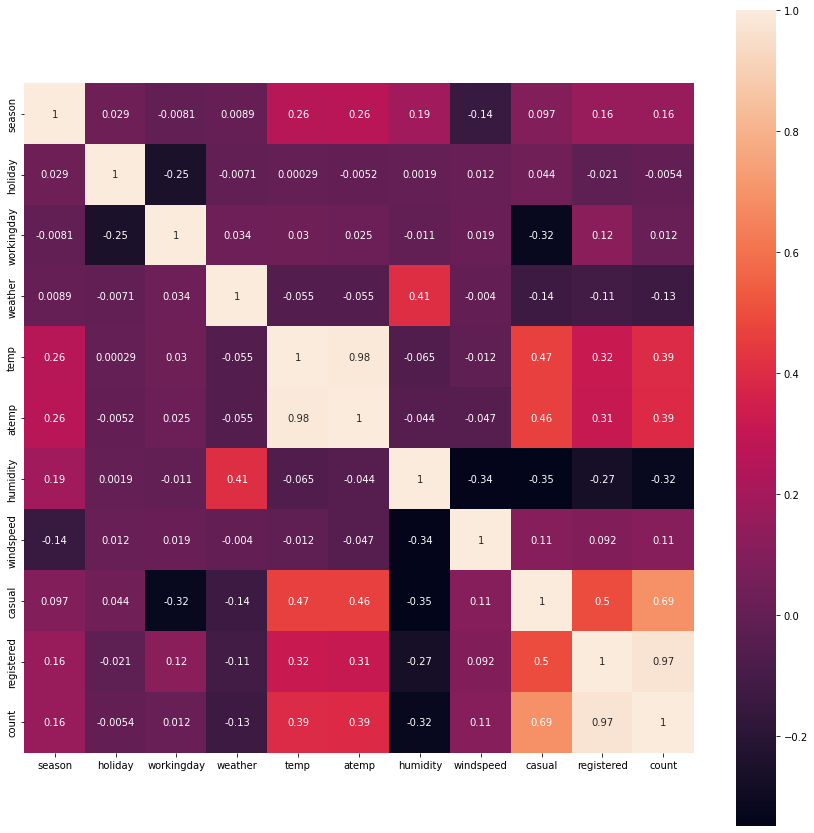

In [97]:
#windspeed를 수정한 후 다시 상관계수를 분석
#우리의 기대와는 달리 windspeed와 count의 상관관계는 0.1에서 0.11로 간소한 차이만 보임.
fig = plt.figure(figsize=[15,15])
ax = sns.heatmap(train.corr(),annot=True,square=True)

Min value of windspeed is 6.0032


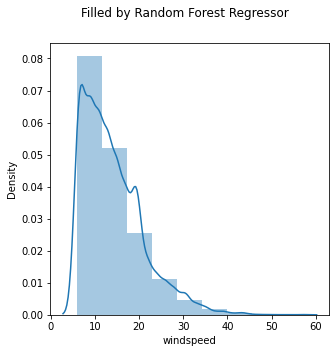

In [98]:
fig = plt.figure(figsize=[5,5])
sns.distplot(train['windspeed'],bins=np.linspace(train['windspeed'].min(),train['windspeed'].max(),10))
plt.suptitle("Filled by Random Forest Regressor")
print("Min value of windspeed is {}".format(train['windspeed'].min()))

In [100]:
"""이제 모든 동일한 전처리 과정을 test셋과 한꺼번에 진행"""
train = pd.read_csv('/content/bike-sharing-demand/train.csv')
test = pd.read_csv('/content/bike-sharing-demand/test.csv')

combine = pd.concat([train,test],axis=0)

In [101]:
combine['tempDate'] = combine.datetime.apply(lambda x:x.split())
combine['weekday'] = combine.tempDate.apply(lambda x: calendar.day_name[datetime.strptime(x[0],"%Y-%m-%d").weekday()])
combine['year'] = combine.tempDate.apply(lambda x: x[0].split('-')[0])
combine['month'] = combine.tempDate.apply(lambda x: x[0].split('-')[1])
combine['day'] = combine.tempDate.apply(lambda x: x[0].split('-')[2])
combine['hour'] = combine.tempDate.apply(lambda x: x[1].split(':')[0])

combine['year'] = pd.to_numeric(combine.year,errors='coerce')
combine['month'] = pd.to_numeric(combine.month,errors='coerce')
combine['day'] = pd.to_numeric(combine.day,errors='coerce')
combine['hour'] = pd.to_numeric(combine.hour,errors='coerce')

combine['season'] = combine.month.apply(badToRight)

In [102]:
combine.weekday = combine.weekday.astype('category')

combine.weekday.cat.categories = ['5','1','6','0','4','2','3']

dataWind0 = combine[combine['windspeed']==0]
dataWindNot0 = combine[combine['windspeed']!=0]

dataWind0_df = dataWind0.drop(['windspeed','casual','registered','count','datetime','tempDate'],axis=1)

dataWindNot0_df = dataWindNot0.drop(['windspeed','casual','registered','count','datetime','tempDate'],axis=1)
dataWindNot0_series = dataWindNot0['windspeed']

In [103]:
rf2 = RandomForestRegressor()
rf2.fit(dataWindNot0_df,dataWindNot0_series)
predicted = rf2.predict(dataWind0_df)
print(predicted)

dataWind0['windspeed'] = predicted

[ 7.292481  6.662681  6.602783 ...  8.042077 25.310389 10.100987]


In [104]:
combine = pd.concat([dataWind0,dataWindNot0],axis=0)

categorizational_columns = ['holiday','humidity','season','weather','workingday','year','month','day','hour']
drop_columns = ['datetime','casual','registered','count','tempDate']

#categorical하게 변환
for col in categorizational_columns:
    combine[col] = combine[col].astype('category')

#합쳐진 combine데이터 셋에서 count의 유무로 훈련과 테스트셋을 분리하고 각각을 datetime으로 정렬
train = combine[pd.notnull(combine['count'])].sort_values(by='datetime')
test = combine[~pd.notnull(combine['count'])].sort_values(by='datetime')

#데이터 훈련시 집어 넣게 될 각각의 결과 값들
datetimecol = test['datetime']
yLabels = train['count'] #count
yLabelsRegistered = train['registered'] #등록된 사용자
yLabelsCasual = train['casual'] #임시 사용자

#필요 없는 column들을 버린 후의 훈련과 테스트 셋
train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)

In [105]:
"""
해당 문제에서는 RMSLE방식을 이용하여 제대로 예측이 되었는지 평가하게 됨.
RMSLE는 아래 링크를 참조하여 이용.
https://programmers.co.kr/learn/courses/21/lessons/943#

RMSLE
과대평가 된 항목보다는 과소평가 된 항목에 페널티를 주는방식
오차를 제곱하여 형균한 값의 제곱근으로 값이 작아질 수록 정밀도가 높음
0에 가까운 값이 나올 수록 정밀도가 높다
"""

# y is predict value y_ is actual value
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [106]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

lr = LinearRegression()

"""
아래의 커널을 참조하여 yLabels를 로그화 하려는데 왜 np.log가 아닌 np.log1p를 활용하는가??
np.log1p는 np.log(1+x)와 동일. 이유는 만약 어떤 x값이 0인데 이를 log하게되면, (-)무한대로 수렴하기 때문에 np.log1p를 활용함. 
참조: https://ko.wikipedia.org/wiki/%EB%A1%9C%EA%B7%B8 
"""
yLabelslog = np.log1p(yLabels)
#선형 모델에 우리의 데이터를 학습
lr.fit(train,yLabelslog)
#결과 값 도출
preds = lr.predict(train)
#rmsle함수의 element에 np.exp()지수 함수를 취하는 이유는 우리의 preds값에 얻어진 것은 한번 log를 한 값이기 때문에 원래 모델에는 log를 하지 않은 원래의 값을 넣기 위함임.
print('RMSLE Value For Linear Regression: {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value For Linear Regression: 0.9773414077860159


In [109]:
"""
데이터 훈련시 Log값을 취하는 이유??
우리가 결과 값으로 투입하는 Count값이 최저 값과 최고 값의 낙폭이 너무 커서
만약 log를 취하지 않고 해보면 print하는 결과 값이 inf(infinity)로 뜨게 됨
"""

"""
GridSearchCV를 활용하면 우리가 이용하게 될 각각의 모델마다 변경해야 하는 파라미터 튜닝시 어떤 파라미터가 최적의 값을 내는지 등을 알 수 있음.

GridSearchCV 참조:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://datascienceschool.net/view-notebook/ff4b5d491cc34f94aea04baca86fbef8/
"""
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#Ridge모델은 L2제약을 가지는 선형회귀모델에서 개선된 모델이며 해당 모델에서 유의 깊게 튜닝해야하는 파라미터는 alpha값이다.
ridge = Ridge()

#우리가 튜닝하고자하는 Ridge의 파라미터 중 특정 파라미터에 배열 값으로 넘겨주게 되면 테스트 후 어떤 파라미터가 최적의 값인지 알려줌 
ridge_params = {'max_iter':[3000],'alpha':[0.001,0.01,0.1,1,10,100,1000]}
rmsle_scorer = metrics.make_scorer(rmsle,greater_is_better=False)
grid_ridge = GridSearchCV(ridge,ridge_params,scoring=rmsle_scorer,cv=5)

grid_ridge.fit(train,yLabelslog)
preds = grid_ridge.predict(train)
print(grid_ridge.best_params_)
print('RMSLE Value for Ridge Regression {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value for Ridge Regression 0.977341407539626


In [110]:
#Ridge모델은 L1제약을 가지는 선형회귀모델에서 개선된 모델이며 해당 모델에서 유의 깊게 튜닝해야하는 파라미터는 alpha값이다.
lasso = Lasso()

lasso_params = {'max_iter':[3000],'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_lasso = GridSearchCV(lasso,lasso_params,scoring=rmsle_scorer,cv=5)
grid_lasso.fit(train,yLabelslog)
preds = grid_lasso.predict(train)
print('RMSLE Value for Lasso Regression {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value for Lasso Regression 0.9773509235367187


In [111]:
rf = RandomForestRegressor()

rf_params = {'n_estimators':[1,10,100]}
grid_rf = GridSearchCV(rf,rf_params,scoring=rmsle_scorer,cv=5)
grid_rf.fit(train,yLabelslog)
preds = grid_rf.predict(train)
print('RMSLE Value for RandomForest {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value for RandomForest 0.10289118333941646


In [112]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb_params={'max_depth':range(1,11,1),'n_estimators':[1,10,100]}
grid_gb=GridSearchCV(gb,gb_params,scoring=rmsle_scorer,cv=5)
grid_gb.fit(train,yLabelslog)
preds = grid_gb.predict(train)
print('RMSLE Value for GradientBoosting {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value for GradientBoosting 0.2061368615746995


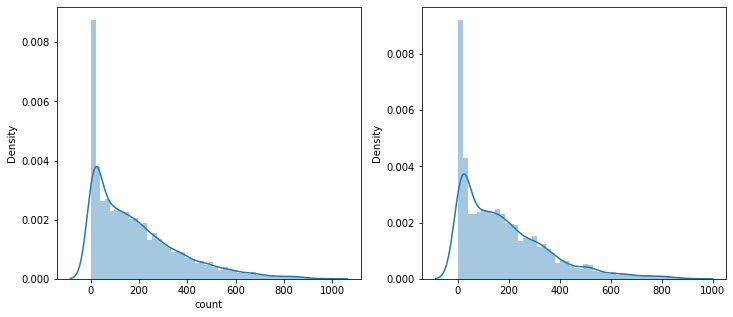

In [113]:
predsTest = grid_gb.predict(test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yLabels,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [114]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)